# Projektarbeit Winequality

[Read CSV Files](#section-title)

In [1]:
#Basics
import numpy as np
import pandas as pd

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

#PCA
from sklearn.decomposition import PCA as sk_pca
from sklearn.preprocessing import StandardScaler, normalize, RobustScaler

#Preprocessing
from sklearn import svm
from sklearn.cluster import KMeans
from scipy.signal import savgol_filter

#Regression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier


#Hilfsskripte
from Preprocessing_aux import *
from plotfunctions import *

%load_ext autoreload
%autoreload 2

## Read CSV Files

In [2]:

#Importing
red_wine= pd.read_csv('winequality-red.csv', sep=';')
white_wine = pd.read_csv('winequality-white.csv', sep=';')

#Combinde both Datasets
red_wine['Wine type'] = 'red wine'
white_wine['Wine type'] = 'white wine'
all_wine = pd.concat([red_wine,white_wine], ignore_index=True)
display(red_wine.head(2),red_wine.shape,
        white_wine.head(2), white_wine.shape,
        all_wine.tail(2), all_wine.shape)

#Column headings including units
units_list = ['Fixed acidity (g(tartaric acid)/dm3)','Volatile acidity (g(acetic acid)/dm3)','Citric acid (g/dm3)','Residual sugar (g/dm3)',
'Chlorides (g(sodium chloride)/dm3)','Free sulfur dioxide (mg/dm3)', 'Total sulfur dioxide (mg/dm3)', 'Density (g/cm3)','pH',
 'Sulphates (g(potassium sulphate)/dm3)','Alcohol (vol.%)', 'Sensory preferences']

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Wine type
0,7.4,0.70,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red wine
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red wine


(1599, 13)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Wine type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6,white wine
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6,white wine


(4898, 13)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Wine type
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white wine
6496,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,white wine


(6497, 13)

## Statistical overview of sensory preference levels and attributes

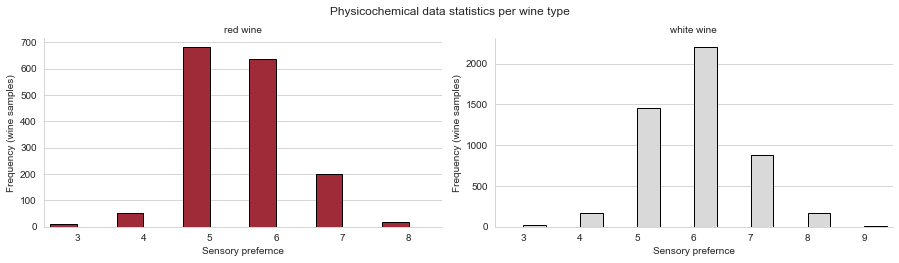

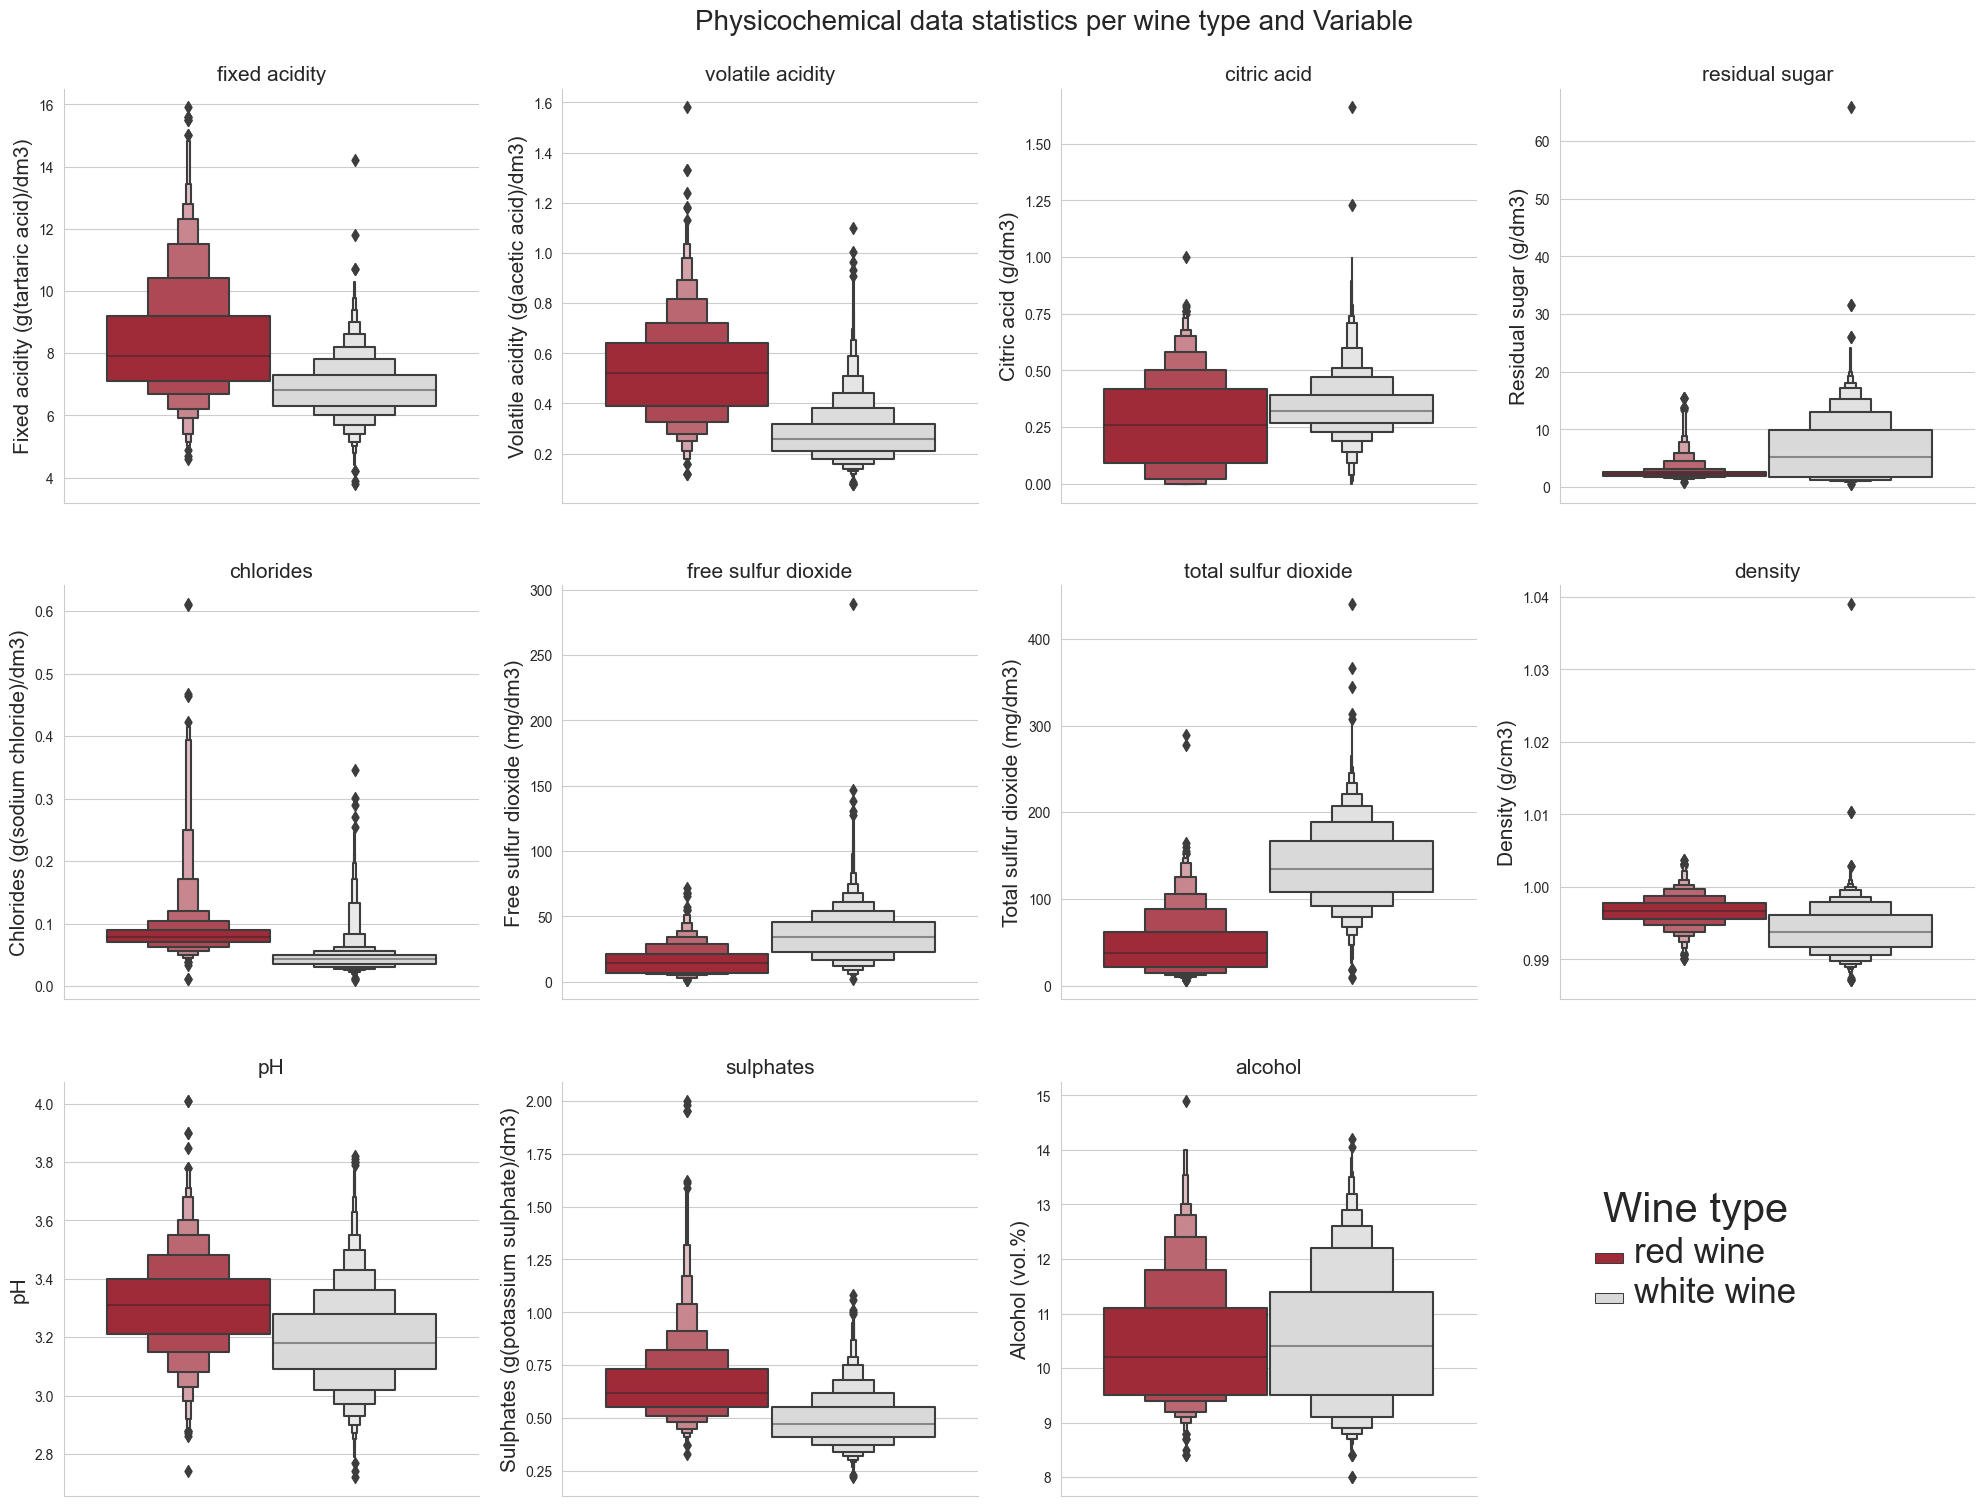

In [3]:
#Visulatisation Set up
color_wine= ['#b2182b','#d9d9d9']
sns.set_style('whitegrid')

#Plot of the sensory preferences
s=sns.catplot(data=all_wine, kind='count', hue='Wine type',col='Wine type', col_wrap=2, x='quality',sharey=False, sharex= False, height=3.5, aspect=1.8,
palette=color_wine, edgecolor = 'black')

    #Customization
s.fig.suptitle('Physicochemical data statistics per wine type', y=1.03)
s.set_titles('{col_name}')
s.set(xlabel='Sensory prefernce', ylabel='Frequency (wine samples)')

#Plot of the physicochemical data
phys_df=all_wine.melt(id_vars=['Wine type', 'quality'])
phys_df['name']=phys_df.variable
p=sns.catplot(data=phys_df,kind='boxen', x='variable', y='value', col="name", col_wrap=4, hue="Wine type", sharey=False, sharex=False, palette=color_wine)

    #Customization
    #Function to use on later plots with similar  layout
def phys_df_labeles(plot, title,tick='',xlab=None):
    #Title 
    plot.fig.suptitle(title, y=1.03, size = 20)
    plot.set_titles('{col_name}', size = 15)
    
    #Legend
    sns.move_legend(plot, "upper left", bbox_to_anchor=(.75, .25))
    plt.setp(plot._legend.get_title(), fontsize=30)
    plt.setp(plot._legend.get_texts(), fontsize=25)

    #Subplot orientation
    plt.subplots_adjust(hspace=0.2, wspace=0.2)

    #Axis Labels
    plot.set(xlabel=xlab)
    plot.set_xticklabels(tick)
    labels=units_list[0:11]
    for i in np.arange(11):
        plot.axes[i].set_ylabel(labels[i], fontsize=15)
phys_df_labeles(p,'Physicochemical data statistics per wine type and Variable')

### Correletion between features

### Visual examination of the correlation

Text(0.5, 1.01, 'All wine')

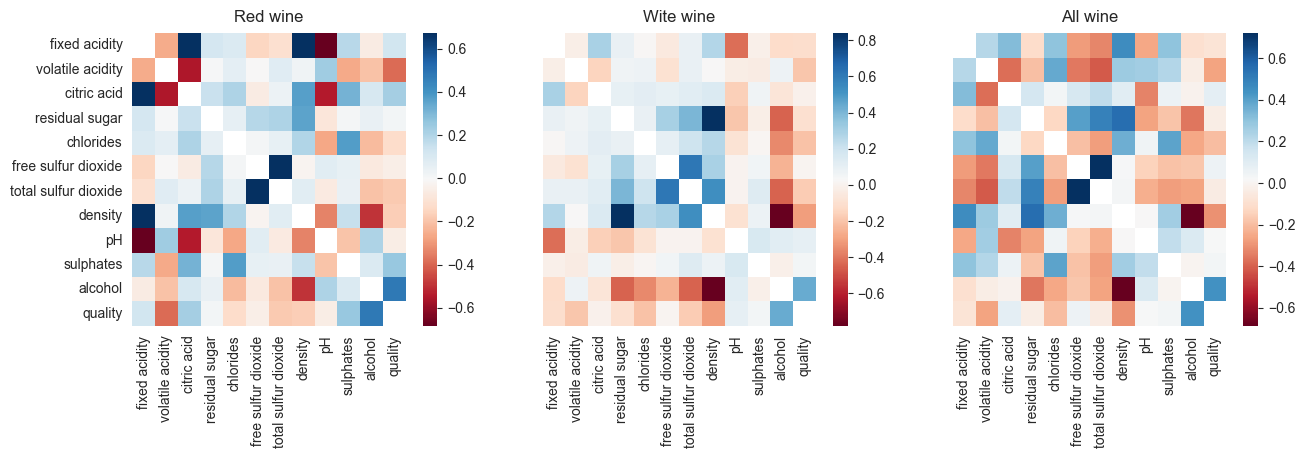

In [4]:
#Filter out correlations equal to 1
filtered_red=red_wine.corr()[red_wine.corr() != 1]
filtered_white=white_wine.corr()[white_wine.corr() != 1]
filtered_all = all_wine.corr()[all_wine.corr() != 1]

#Set up colour palette
c=sns.color_palette('RdBu', as_cmap=True)

#Plot
fig,(ax,ax1, ax2)=plt.subplots(ncols=3, sharey = True, figsize=(15,3.8))
sns.heatmap(filtered_red, cmap=c, ax=ax)
ax.set_title('Red wine', y=1.01)
sns.heatmap(filtered_white, cmap=c, ax=ax1)
ax1.set_title('Wite wine', y=1.01)
sns.heatmap(filtered_all, cmap=c, ax=ax2)
ax2.set_title('All wine', y=1.01)

### Finding the strongest correlated attribute for each individual attribute

In [5]:
#Finding highest Correlation
def high_corr(x):
    highest_corr = []
    for label, row in x.iterrows():
        features = []
        features.append(label)
        
        #find local max/min
        index_max_min = np.argmax(abs(row))
        index_max_min = x.columns[index_max_min]
        features.append(index_max_min)

        actual_rowmaxmin = row[index_max_min]
        features.append(actual_rowmaxmin)

        #Move new list in 'highest_corr'
        highest_corr.append(features)
    highest_corr = pd.DataFrame(highest_corr)
    highest_corr.columns = ["Feature_1", "Feature_2", "Pearson_Correlation"]
    highest_corr['Pearson_Correlation_abs']=abs(highest_corr['Pearson_Correlation'])
    highest_corr['1']=1
    return highest_corr.sort_values("Pearson_Correlation_abs", ascending = False)
red_corr = high_corr(filtered_red)
white_corr = high_corr(filtered_white)
all_corr =high_corr(filtered_all)

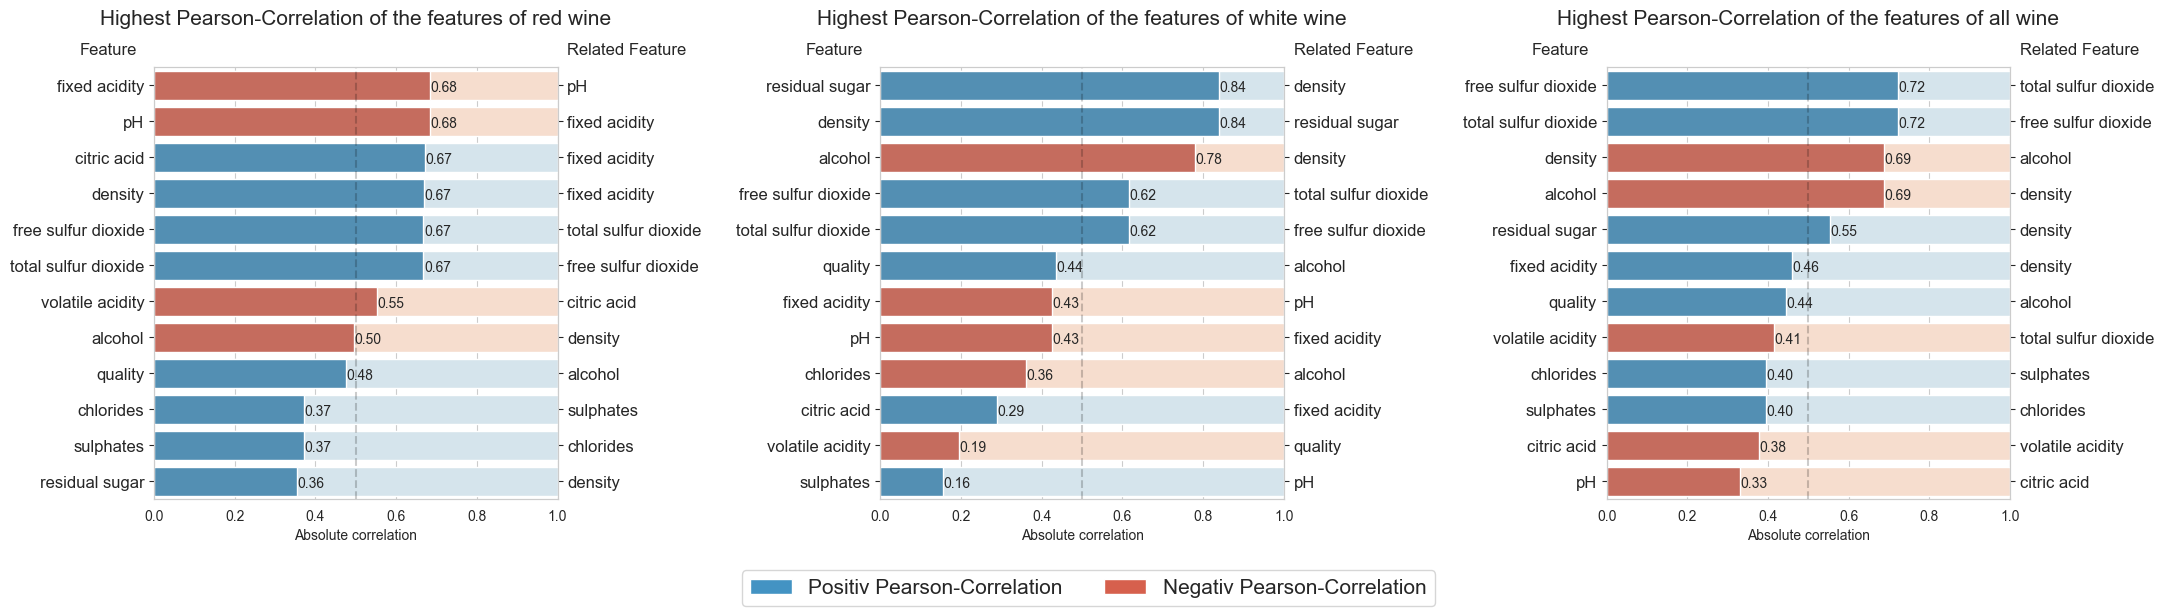

In [6]:
#Visalization

#Colour set up
range = [-1,0,1]
colours= ['#d6604d', '#4393c3']
colours_2=['#fddbc7','#d1e5f0']

#Set up for Subplot
sns.set_style('whitegrid')
fig, (ax, axb, axc) = plt.subplots(ncols=3)

# bar chart 1 -> top bars

for a, df, tit in zip([ax, axb, axc], [red_corr, white_corr, all_corr], ['red wine', 'white wine', 'all wine']):
    #Colorlist
    hue_colours=pd.cut(df['Pearson_Correlation'], bins=range, labels=colours).values
    hue_colours_2=pd.cut(df['Pearson_Correlation'], bins=range, labels=colours_2).values

    #Creat Twin x-axis
    a1=a.twinx()

    #Plot data
    p=sns.barplot(y="Feature_1", x="Pearson_Correlation_abs", data=df, palette=hue_colours, ax=a1)
    a1.set_yticklabels(df['Feature_2'].values, fontsize=12)
    a1.set_ylabel('')
    show_values(p, "h", space=0.001)
    
    #Title
    plt.title('Highest Pearson-Correlation of the features of {}'.format(tit), y=1.08, fontsize=15)
    plt.title('Feature', loc='left', x=-0.185, y=1.01)
    plt.title('Related Feature', loc='right', x=1.32, y=1.01)

    #Second Plot to shwo the corelacted feature
    sns.barplot(y="Feature_1",  x="1", data=df, palette=hue_colours_2 , ax=a)
    a.set_ylabel('')
    a.set_yticklabels(df['Feature_1'].values, fontsize=12)
    plt.xlim(0, 1)
    a.set(xlabel='Absolute correlation')
 
    #Create dottet line at Correlatio = 0.5
    a1.axvline(x = 0.5, linestyle = "--", alpha = .2, color = "black")

#Adjust subplot positioning
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=3,
                    top=1, 
                    wspace=0.8)
                    
# Create customize legend
legend_elements = [Patch(facecolor='#4393c3',label='Positiv Pearson-Correlation'),
                    Patch(facecolor='#d6604d',label='Negativ Pearson-Correlation')]
axb.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.4, -0.14), ncol=2, fontsize=15)

plt.show()

### Relation between sensory prefernce and individual features

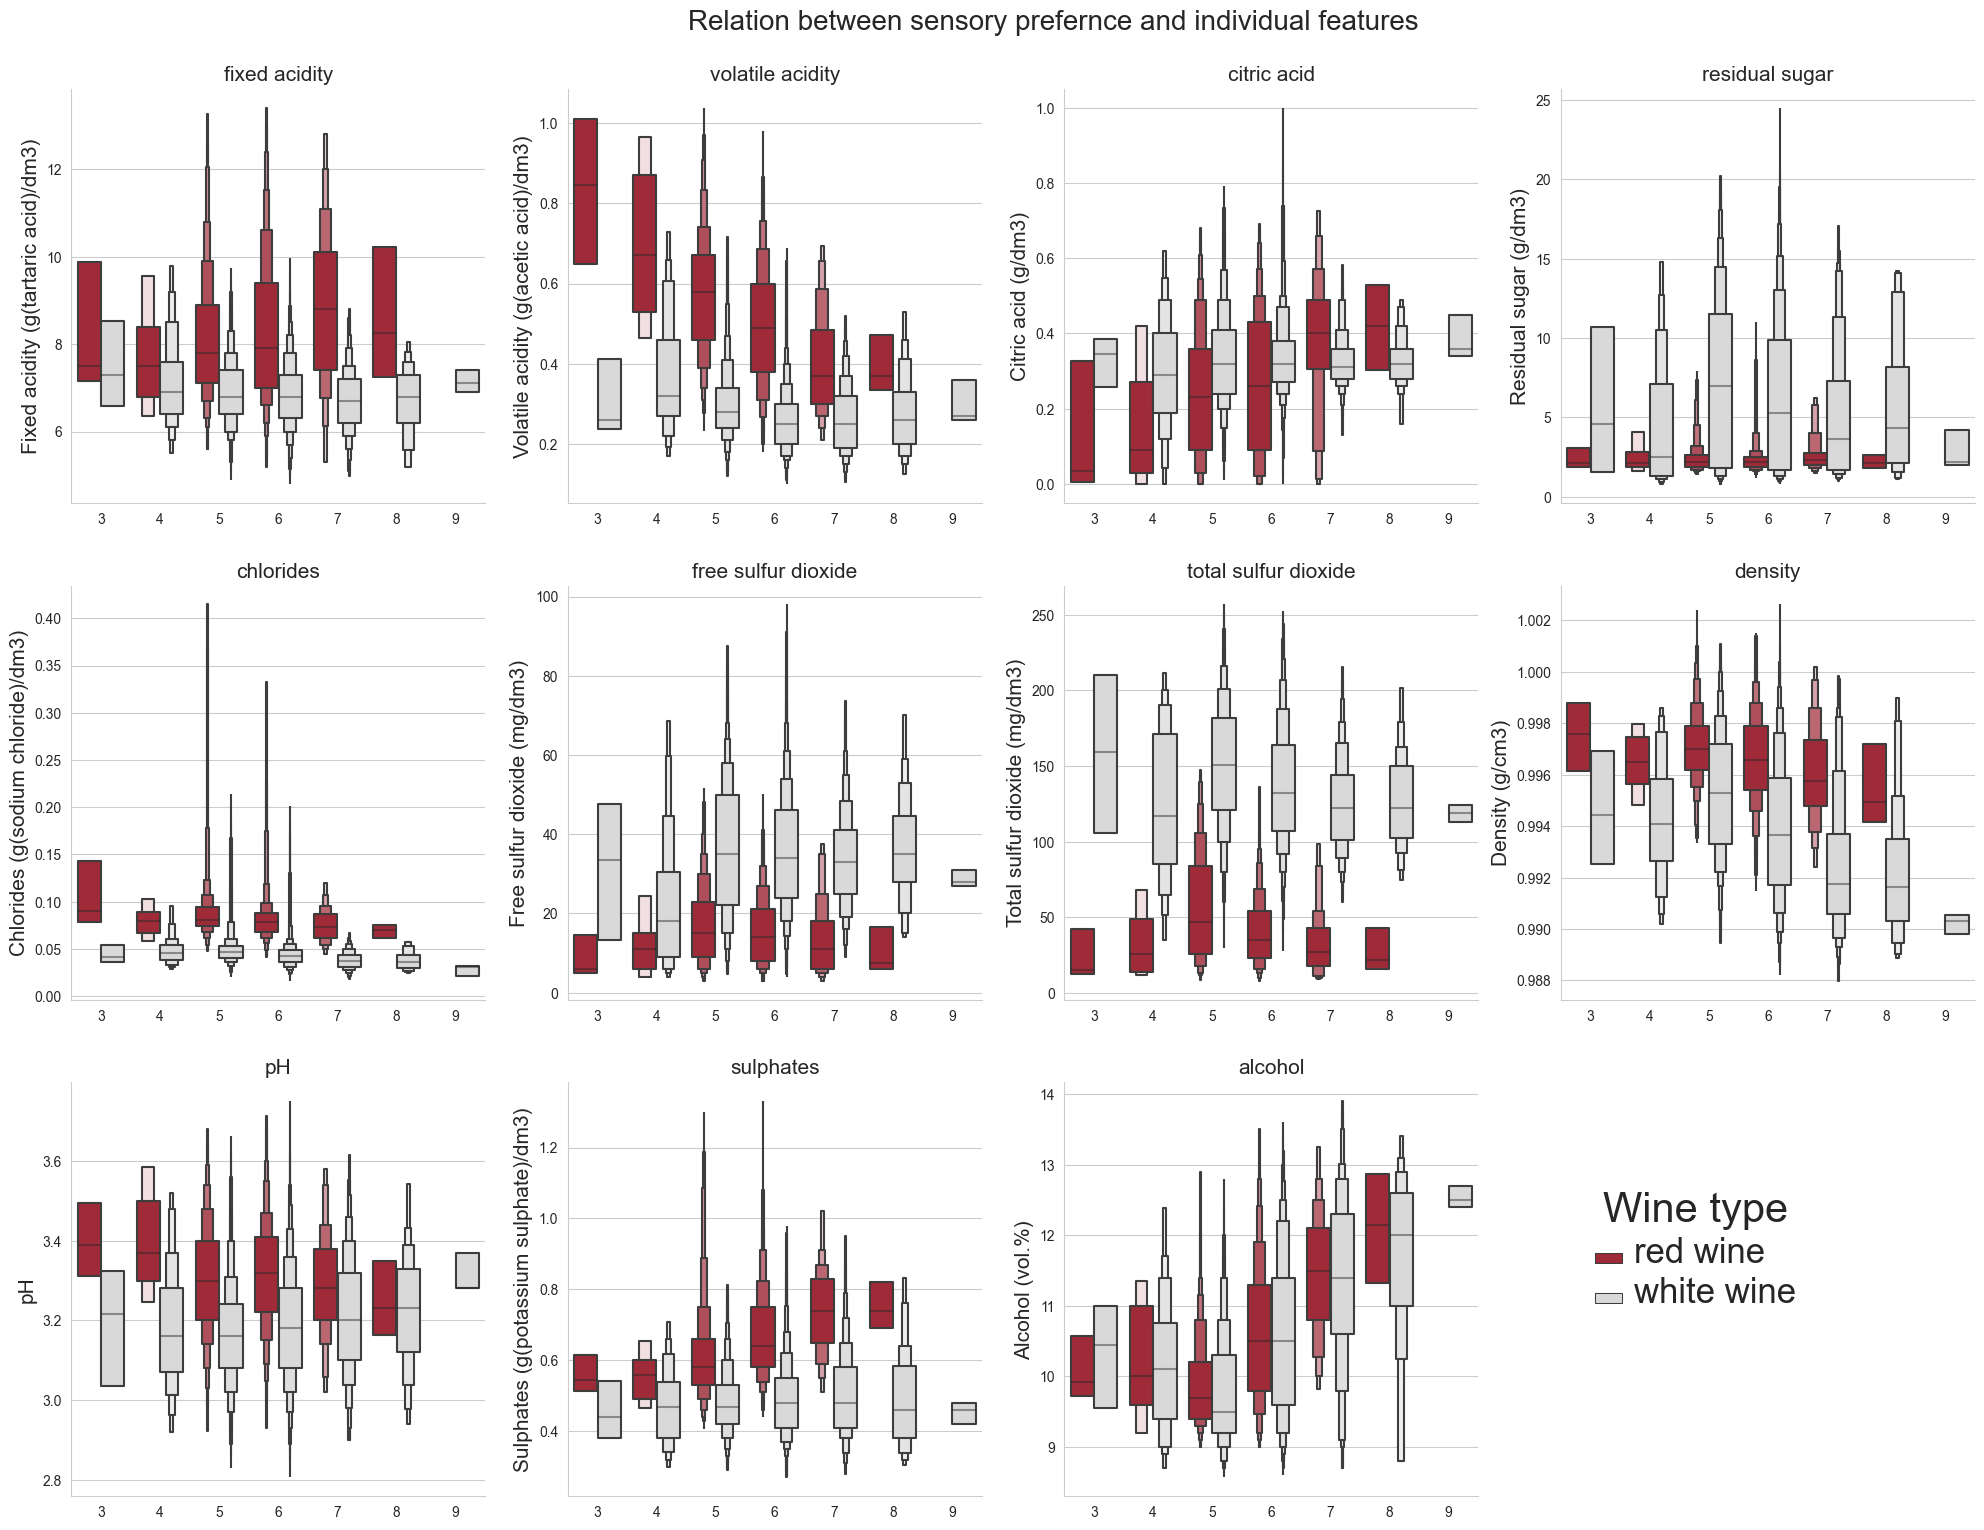

In [7]:
c=sns.catplot(data=phys_df, y='value', x="quality", kind='boxen', col='variable',col_wrap=4, hue="Wine type",palette=color_wine,
 sharey=False, sharex=False, showfliers=False)
phys_df_labeles(c,'Relation between sensory prefernce and individual features',tick=[3,4,5,6,7,8,9])

### Quantitative correlation between sensory prefernce and individual features

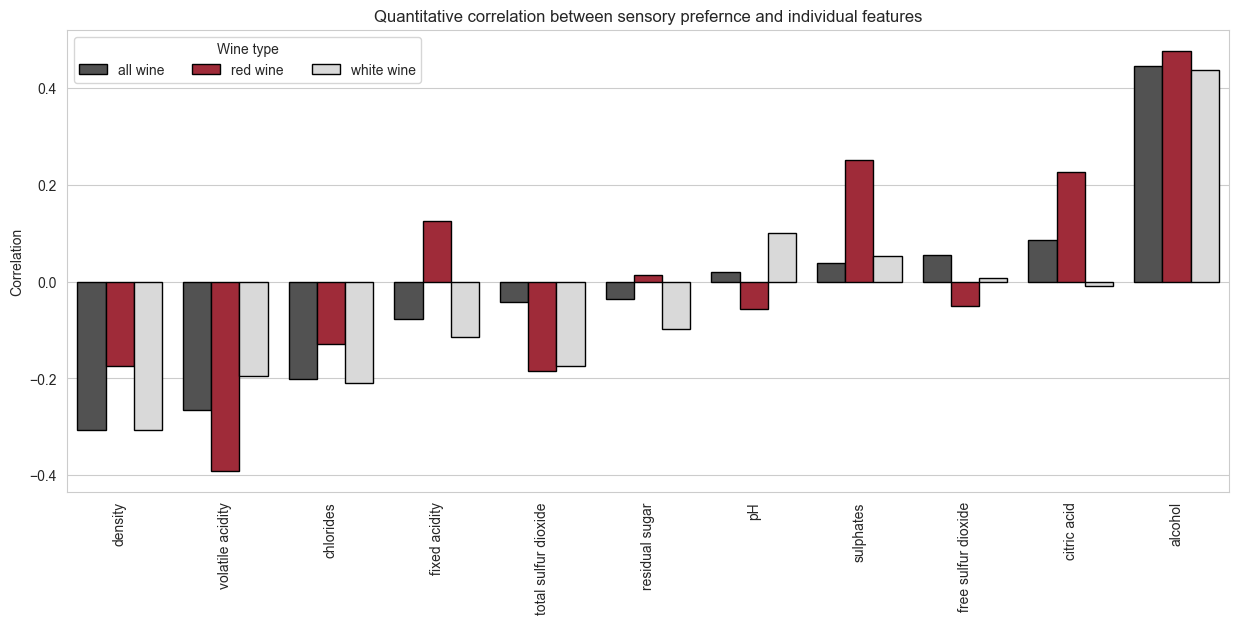

In [8]:
#Get Wine type label to DataFrame; using filtered DataFrames from before
filtered_red['Wine type']='red wine'
filtered_white['Wine type']='white wine'
filtered_all['Wine type']='all wine'

#Concate all 3 DataFrames into one
corr_quality=pd.concat([filtered_red[:-1],filtered_white[:-1], filtered_all[:-1]])

#Filter DataFrame to use only needed columns
corr_quality.reset_index(inplace=True)
corr_quality=corr_quality.iloc[:,[0,12,13]]
corr_quality.sort_values(['Wine type','quality'],inplace=True)

#Set up for Subplot
sns.set_style('whitegrid')
colours_wine= ['#525252','#b2182b','#d9d9d9']

#Plot data
fig,ax=plt.subplots(figsize=(15,6))

g=sns.barplot(x="index", y="quality", data=corr_quality,hue='Wine type', palette=colours_wine, ax=ax,  edgecolor = 'black')
plt.xticks(rotation=90)
plt.legend(title='Wine type', ncol=3)
g.set_title('Quantitative correlation between sensory prefernce and individual features')
g.set_ylabel('Correlation')
g.set_xlabel('')
plt.show()

### Predict sensory preference from features

c:\Users\felix_9ny56v1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\felix_9ny56v1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

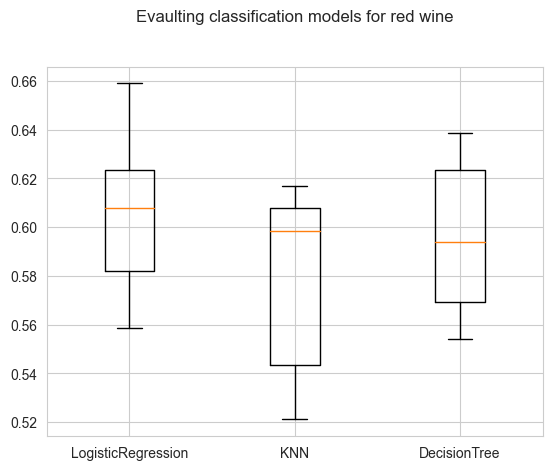

The classification model used for red wine is LogisticRegression


c:\Users\felix_9ny56v1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\felix_9ny56v1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\felix_9ny56v1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metric

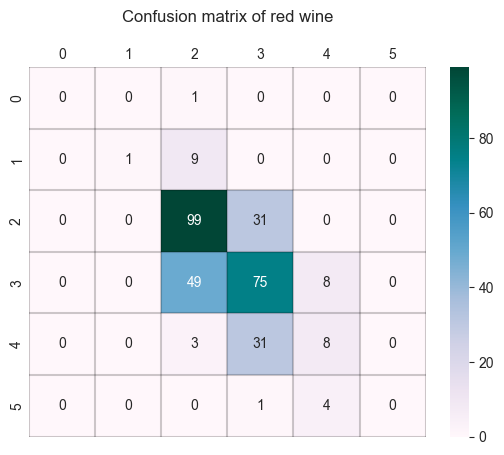

c:\Users\felix_9ny56v1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\felix_9ny56v1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

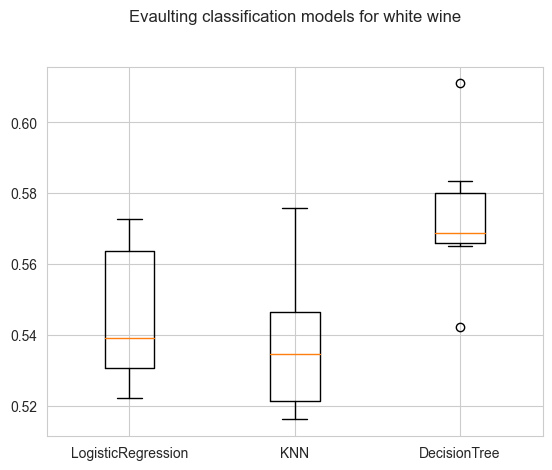

The classification model used for white wine is DecisionTree


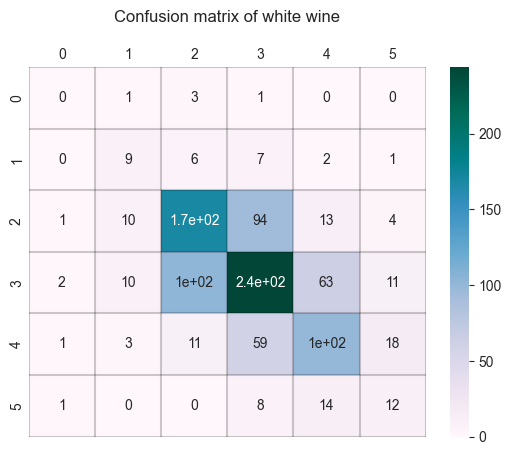

c:\Users\felix_9ny56v1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\felix_9ny56v1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

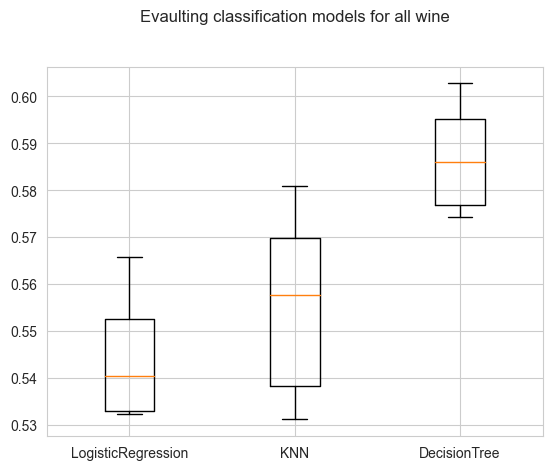

The classification model used for all wine is DecisionTree


c:\Users\felix_9ny56v1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\felix_9ny56v1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\felix_9ny56v1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

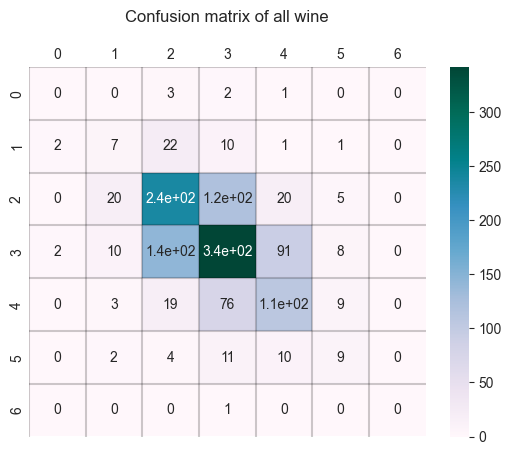

In [9]:
#Funktion to change to input into the Regession model
def reg_func(data=[red_wine, white_wine, all_wine], names=['red wine', 'white wine', 'all wine']):
    #Set up the linaer regression models
    for df,name in zip(data, names):
        X=df.drop(['quality', 'Wine type'], axis =1)
        y=df['quality']
        #Split in Test and Train
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
        X_train_scaled= StandardScaler().fit_transform(X_train)
        X_test_scaled= StandardScaler().fit_transform(X_test)

        #Evaulting classification models
        models={'LogisticRegression': LogisticRegression(), 'KNN':KNeighborsClassifier(), 'DecisionTree': DecisionTreeClassifier()}
        results=[]
        for model in models.values():
            kf=KFold(n_splits=6, shuffle=True,random_state=42)
            cv_result=cross_val_score(model, X_train_scaled, y_train, cv=kf)
            results.append(cv_result)
        
        #Visualisation of results
        a=plt.boxplot(results, labels=models.keys())
        plt.title('Evaulting classification models for {}'.format(name), y=1.1)
        plt.show()

        #Checks with models creats the best results
        if results[0].mean() > results[1].mean():
            if results[0].mean() > results[2].mean():
                reg=LogisticRegression()
                print('The classification model used for {} is LogisticRegression'.format(name))
            else:
                reg=DecisionTreeClassifier()
                print('The classification model used for {} is DecisionTree'.format(name))
        elif results[1].mean() > results[2].mean():
            reg=KNeighborsClassifier()
            print('The classification model used for {} is KNN'.format(name))
        else:
            reg=DecisionTreeClassifier()
            print('The classification model used for {} is DecisionTree'.format(name))
        
        #Fitting model to train data
        reg.fit(X_train_scaled, y_train)

        #Predicting Target
        y_pred=reg.predict(X_test_scaled)

        #Creating Stat. Report
        report=classification_report(y_test,y_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        
        #Cinfusion Matrix
        con_mat=confusion_matrix(y_test, y_pred)
        
        
        #Visualtisiton of Confusion Matrix as Heatmap
        PuBuGn=sns.color_palette('PuBuGn', as_cmap=True)
        g=sns.heatmap(con_mat,  cmap=PuBuGn, annot=True)
        g.xaxis.tick_top() 
        g.tick_params(length=0)# x axis on top
        g.xaxis.set_label_position('top')
        g.set_title('Confusion matrix of {}'.format(name), y=1.1)
        for i in np.arange(0,7):
            g.axvline(x = i, linestyle = "-", alpha = .2, color = "black")
            g.axhline(y = i, linestyle = "-", alpha = .2, color = "black")
        plt.show()  

reg_func()

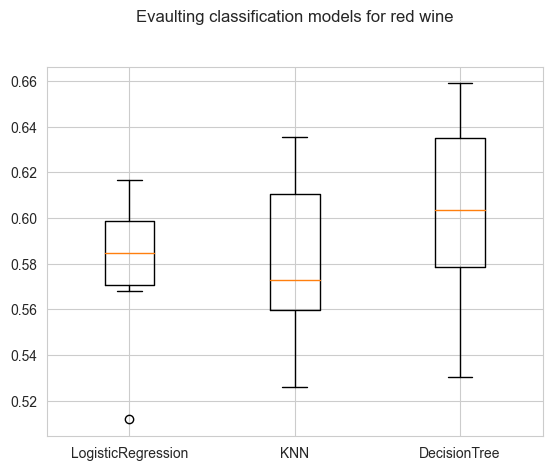

The classification model used for red wine is DecisionTree


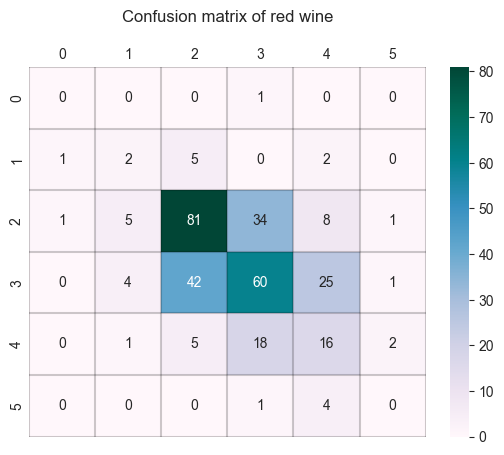

c:\Users\felix_9ny56v1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\felix_9ny56v1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

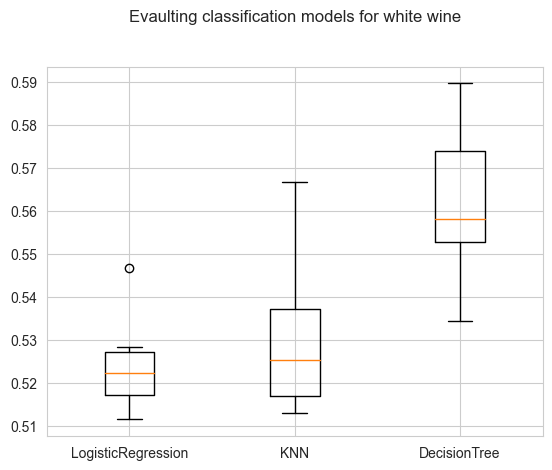

The classification model used for white wine is DecisionTree


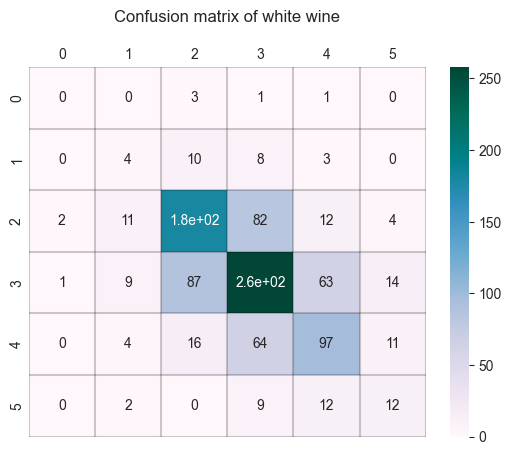

c:\Users\felix_9ny56v1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


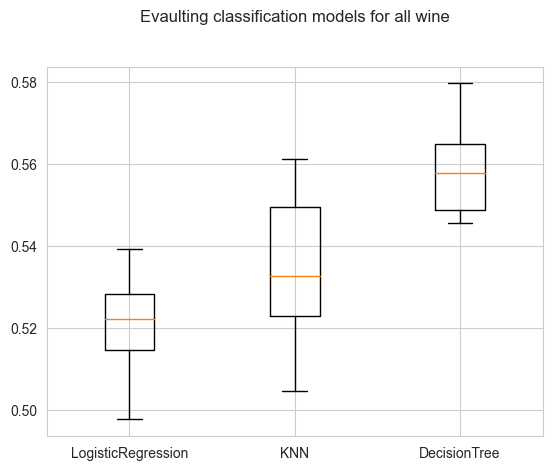

The classification model used for all wine is DecisionTree


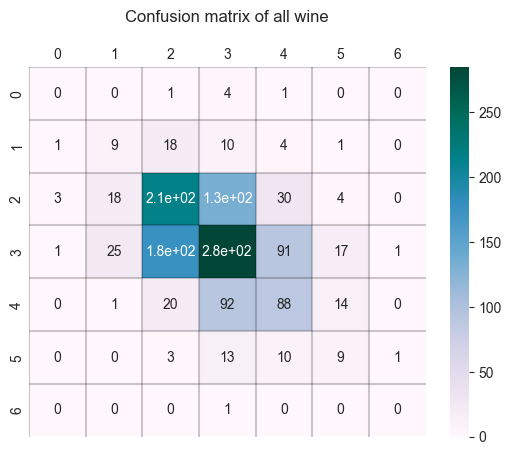

In [10]:
reg_func(data=[red_wine.iloc[:,[1,9,8,10,11,12]], white_wine.iloc[:,[0,1,2,4,10,11,12]], all_wine.iloc[:,[0,1,2,10,11,12]]])

### Hyperparamter tuning

In [11]:
#Hyperparameter Dectree tuning
#List Hyperparameters that we want to tune.
df=red_wine
X=df.drop(['quality', 'Wine type'], axis =1)
y=df['quality']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
kf=KFold(n_splits=6, shuffle=True,random_state=42)
leaf_size = list(np.arange(1,50))
n_neighbors = list(np.arange(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=kf)
#Fit the model
best_model = clf.fit(X_train,y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best score:', best_model.best_score_)
test_score=best_model.score(X_test,y_test)
print(test_score)

Best leaf_size: 1
Best p: 2
Best n_neighbors: 1
Best score: 0.5652779605984819
0.50625


In [12]:
#Hyperparameter tuning
kf=KFold(n_splits=6, shuffle=True,random_state=42)

lasso_cv=GridSearchCV(lasso, param_grid, cv=kf)
lasso_cv.fit(X_train_scaled, y_train)
print("Tuned lasso paramaters: {}".format(lasso_cv.best_params_))
print("Tuned lasso score: {}".format(lasso_cv.best_score_))


NameError: name 'lasso' is not defined